# Carga y exploración de datos

### Importación de librerias

In [37]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import kruskal

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler  # o MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

### Importa el dataset Celular.csv en un Jupyter Notebook con pandas

In [2]:
dataset = pd.read_csv("Celular.csv")
dataset.head()

,salario,economias,edad,deudas,plan
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


### Verifica valores faltantes y distribuciones de cada variable

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   salario    150 non-null    float64
 1   economias  150 non-null    float64
 2   edad       150 non-null    float64
 3   deudas     150 non-null    float64
 4   plan       150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [7]:
dataset.shape

(150, 5)

In [10]:
# Tipos de plan
dataset["plan"].unique()

array([1, 2, 3])

In [8]:
dataset.describe()

,salario,economias,edad,deudas,plan
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667,2.000000
std,0.828066,0.433594,1.764420,0.763161,0.819232
min,4.300000,2.000000,1.000000,0.100000,1.000000
25%,5.100000,2.800000,1.600000,0.300000,1.000000
50%,5.800000,3.000000,4.350000,1.300000,2.000000
75%,6.400000,3.300000,5.100000,1.800000,3.000000
max,7.900000,4.400000,6.900000,2.500000,3.000000


# Analisis exploratorio

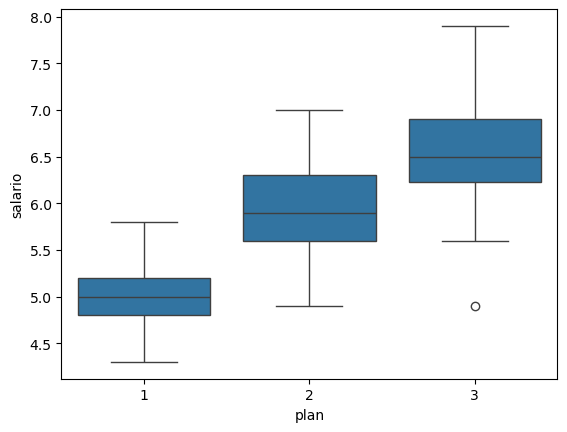

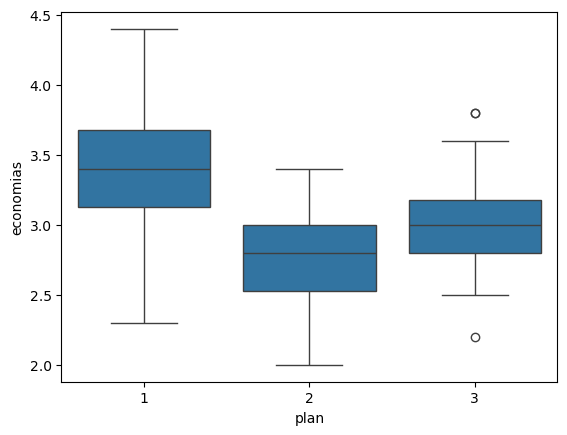

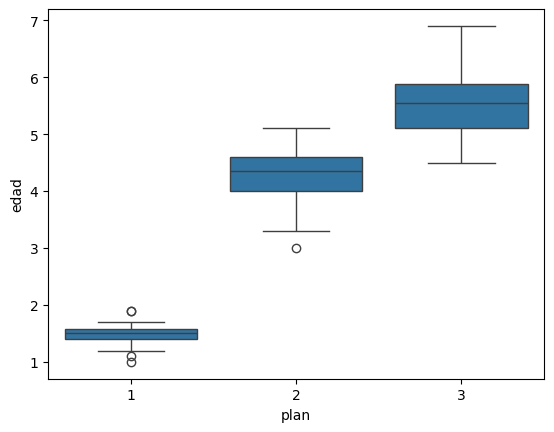

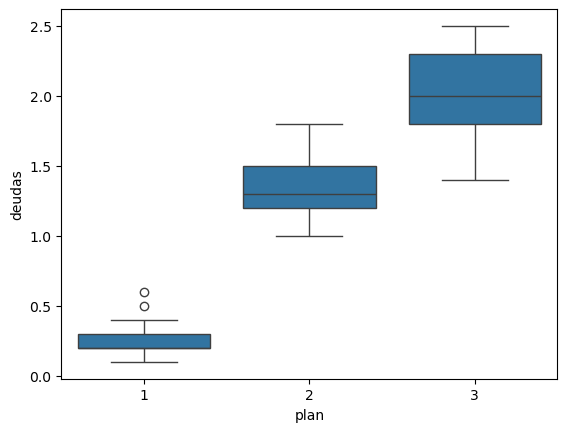

In [14]:
for col in ["salario", "economias", "edad", "deudas"]:
    sns.boxplot(x="plan", y=col, data=dataset)
    plt.show()

In [24]:
# Kruskal-Wallis:
# Si el p-value < 0.05, hay evidencia de que esa variable numérica está relacionada con la clase plan.
for col in ["salario", "economias", "edad", "deudas"]:
    groups = [dataset[dataset["plan"] == p][col] for p in dataset["plan"].unique()]
    stat, pval = kruskal(*groups)
    print(col, "p-value:", pval)

# Todas lass variables tienen p-value < 0.05, entonces hay evidencia de que todas las variables están relacionadas con plan.

salario p-value: 8.91873433246198e-22
economias p-value: 2.6882119006774528e-14
edad p-value: 4.7967237479455454e-29
deudas p-value: 3.415387999117524e-29


# Preparación de datos

In [26]:
# Variables predictoras y objetivo
X = dataset[["salario", "economias", "edad", "deudas"]]
y = dataset["plan"]

In [28]:
# Separar en train (70%) y test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)  # estratifica para balancear clases

In [29]:
scaler = StandardScaler() # Convierte a media = 0 y std = 1

In [32]:
X_train_standard = scaler.fit_transform(X_train)
X_test_standard = scaler.fit_transform(X_test)

# Entrenamiento de modelos

### KNN

In [36]:
# Definir el modelo base
knn = KNeighborsClassifier()

# Definir espacio de hiperparámetros para búsqueda
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 15],
    "weights": ["uniform", "distance"],
    "p": [1, 2]   # 1=Manhattan, 2=Euclídea
}

# Búsqueda con validación cruzada
grid = GridSearchCV(
    knn,
    param_grid,
    cv=5,               # validación cruzada estratificada en 5 folds
    scoring="f1_macro", # métrica principal (ajústala según tu caso)
    n_jobs=-1
)
grid.fit(X_train_standard, y_train)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor puntaje CV (F1 macro):", grid.best_score_)

# Evaluar en test con el mejor modelo
best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test_standard)

print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred))

print("\n--- Matriz de Confusión ---")
print(confusion_matrix(y_test, y_pred))

Mejores hiperparámetros: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Mejor puntaje CV (F1 macro): 0.9712820512820514

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       0.82      0.93      0.88        15
           3       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45


--- Matriz de Confusión ---
[[15  0  0]
 [ 0 14  1]
 [ 0  3 12]]


### Arbol de decision

In [38]:
# Modelo base
dt = DecisionTreeClassifier(random_state=42)

# Espacio de hiperparámetros para búsqueda
param_grid = {
    "criterion": ["gini", "entropy"],          # medida de impureza
    "max_depth": [3, 5, 7, 10, None],          # controlar complejidad/profundidad
    "min_samples_split": [2, 5, 10, 20],       # mínimo para dividir un nodo
    "min_samples_leaf": [1, 2, 5, 10],         # mínimo para hoja
    "max_features": [None, "sqrt", "log2"],    # cuántas features evaluar por división
    "class_weight": [None, "balanced"]         # útil si hay desbalance de clases
}

# Búsqueda con validación cruzada
grid = GridSearchCV(
    dt,
    param_grid,
    cv=5,                 # CV estratificada
    scoring="f1_macro",   # métrica principal (ajústala si necesitas)
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor puntaje CV (F1 macro):", grid.best_score_)

# Evaluación en el set de TEST con el mejor modelo
best_dt = grid.best_estimator_
y_pred = best_dt.predict(X_test)

print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred))

print("\n--- Matriz de Confusión ---")
print(confusion_matrix(y_test, y_pred))

# Importancia de variables (interpretabilidad)
importances = pd.Series(best_dt.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n--- Importancia de variables ---")
print(importances)

Mejores hiperparámetros: {'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor puntaje CV (F1 macro): 0.9617094017094019

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       0.86      0.80      0.83        15
           3       0.81      0.87      0.84        15

    accuracy                           0.89        45
   macro avg       0.89      0.89      0.89        45
weighted avg       0.89      0.89      0.89        45


--- Matriz de Confusión ---
[[15  0  0]
 [ 0 12  3]
 [ 0  2 13]]

--- Importancia de variables ---
edad         0.534351
deudas       0.447039
salario      0.011874
economias    0.006736
dtype: float64


El modelo KNN funciona ligeramente mejor que el Arbol de Decisión por que tiene mayor accuracy y macro-f1. El arbol de decisión puede ser buena opcion en caso de tener que explicarle a alguna tercera persona.

# Aplicación practica

In [39]:

# Nuevo cliente
nuevo_cliente = pd.DataFrame([{
    "salario": 5.5,
    "economias": 3.2,
    "edad": 2.0,
    "deudas": 0.3
}])

# KNN
nuevo_cliente_scaled = scaler.transform(nuevo_cliente)
pred_knn = best_knn.predict(nuevo_cliente_scaled)

# DT
pred_dt = best_dt.predict(nuevo_cliente)

print("Predicción con KNN:", pred_knn[0])
print("Predicción con Árbol de Decisión:", pred_dt[0])

Predicción con KNN: 1
Predicción con Árbol de Decisión: 1


# Conclusiones

El modelo KNN fue elegido finalmente porque alcanzó un desempeño ligeramente superior al Árbol de Decisión tanto en validación cruzada como en el conjunto de prueba, con un F1 macro de 0.91 frente a 0.89, lo que significa que clasifica de manera más equilibrada entre las diferentes clases de planes. Además, presentó mayor precisión en la clase 3 y menos errores globales, lo que lo convierte en la opción más confiable para maximizar la exactitud de las predicciones, aun cuando el Árbol ofrece mejor interpretabilidad. En este caso, la prioridad se dio al rendimiento predictivo, por lo cual KNN resulta ser la mejor alternativa.